In [22]:
import pickle
import sys
from pathlib import Path

import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
submission_path = Path("../XTXStarterKit/").as_posix()
if submission_path not in sys.path:
    sys.path.insert(0, submission_path)

In [3]:
import python.utils
import python.model

In [4]:
pd.set_option("max_columns", 10000)
pd.set_option("max_rows", 10000)

In [5]:
%load_ext autoreload
%autoreload 2

### Load data

In [8]:
data_training = pd.read_csv("../data/data-training.csv.gz")

In [9]:
rate_cols = [c for c in data_training.columns if "Rate" in c]
size_cols = [c for c in data_training.columns if "Size" in c]
other_cols = [c for c in data_training.columns if c not in rate_cols and c not in size_cols]
data_training = data_training[rate_cols + size_cols + other_cols]

In [10]:
display(data_training.head(2))
print(len(data_training))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0    1619.5    1620.0    1621.0       NaN       NaN       NaN       NaN   
1    1619.5    1620.0    1621.0    1621.5       NaN       NaN       NaN   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0       NaN       NaN       NaN        NaN        NaN        NaN        NaN   
1       NaN       NaN       NaN        NaN        NaN        NaN        NaN   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
0        NaN    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   
1        NaN    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   
1    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
0     1601.0     1600.0       1.0      10.0      24.0       NaN       NaN   
1     1601.0     1600.0       1.0      10.0      24.0       5.0       NaN   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
0       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
1       NaN       NaN       NaN       NaN       NaN        NaN        NaN   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
0        NaN        NaN        NaN       7.0      10.0       1.0      10.0   
1        NaN        NaN        NaN       7.0      10.0       1.0      10.0   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0      20.0       3.0      20.0      27.0      11.0      14.0       35.0   
1      20.0       3.0      20.0      27.0      11.0      14.0       35.0   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0       10.0        1.0       10.0       13.0 -0.5  
1       10.0        1.0       10.0       13.0 -0.5

2999999


In [11]:
data_training = python.utils.fix_input_df(data_training)

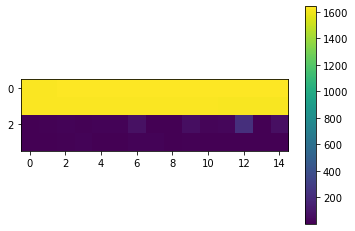

In [12]:
plt.imshow(data_training.drop("y", axis=1).iloc[100200].astype(np.float32).values.reshape(4, 15))
plt.colorbar()

In [13]:
display(data_training.head(2))
print(len(data_training))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0    1619.5    1620.0    1621.0    1621.0    1621.0    1621.0    1621.0   
1    1619.5    1620.0    1621.0    1621.5    1621.5    1621.5    1621.5   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0    1621.0    1621.0    1621.0     1621.0     1621.0     1621.0     1621.0   
1    1621.5    1621.5    1621.5     1621.5     1621.5     1621.5     1621.5   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
0     1621.0    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   
1     1621.5    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   
1    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
0     1601.0     1600.0       1.0      10.0      24.0       0.0       0.0   
1     1601.0     1600.0       1.0      10.0      24.0       5.0       0.0   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
0       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
1       0.0       0.0       0.0       0.0       0.0        0.0        0.0   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
0        0.0        0.0        0.0       7.0      10.0       1.0      10.0   
1        0.0        0.0        0.0       7.0      10.0       1.0      10.0   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0      20.0       3.0      20.0      27.0      11.0      14.0       35.0   
1      20.0       3.0      20.0      27.0      11.0      14.0       35.0   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0       10.0        1.0       10.0       13.0 -0.5  
1       10.0        1.0       10.0       13.0 -0.5

2999999


In [14]:
def normalize_df(df, rate_mean, rate_std, size_mean, size_std):
    for col in df:
        if "Rate" in col:
            df[col] = (df[col] - rate_mean) / rate_std
        elif "Size" in col:
            df[col] = (df[col] - size_mean) / size_std
        else:
            print(col)

In [15]:
TRAIN_TEST_SPLITS = []
for i in range(5):
    start = int(len(data_training) * 0.2 * i)
    stop = int(len(data_training) * 0.2 * (i + 1))
    
    train_df = pd.concat([data_training.iloc[:start], data_training.iloc[stop:]]).copy()
    valid_df = data_training.iloc[start:stop].copy()
    assert len(train_df) + len(valid_df) == len(data_training)
    assert not set(train_df.index) & set(valid_df.index)
    
    rate_mean = train_df[[c for c in train_df.columns if "Rate" in c]].values.mean()
    rate_std = train_df[[c for c in train_df.columns if "Rate" in c]].values.std()
    size_mean = train_df[[c for c in train_df.columns if "Size" in c]].values.mean()
    size_std = train_df[[c for c in train_df.columns if "Size" in c]].values.std()
    print(i, rate_mean, rate_std, size_mean, size_std)

    train_df = python.utils.normalize_df(train_df, rate_mean, rate_std, size_mean, size_std)
    valid_df = python.utils.normalize_df(valid_df, rate_mean, rate_std, size_mean, size_std)

    TRAIN_TEST_SPLITS.append((train_df, valid_df))

0 1644.612596201389 28.54522304768283 17.23235076388889 31.378056039704777


Could not normalize column 'y'.
Could not normalize column 'y'.


1 1637.7148071172808 27.528697193345476 17.976835573681488 33.539837002914624


Could not normalize column 'y'.
Could not normalize column 'y'.


2 1647.1994378539325 26.69847660857911 17.870208626475815 33.81782406661056


Could not normalize column 'y'.
Could not normalize column 'y'.


3 1635.8714673283891 25.095456936983673 16.48420107675045 29.002142948267682


Could not normalize column 'y'.
Could not normalize column 'y'.


4 1644.7164182082297 26.44444556804018 16.40631648874298 30.892679956916375


Could not normalize column 'y'.
Could not normalize column 'y'.


In [18]:
train_df, valid_df = TRAIN_TEST_SPLITS[0]

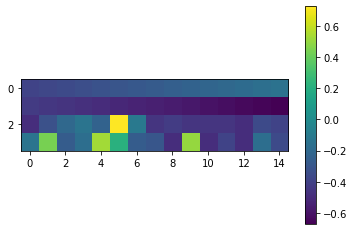

In [19]:
plt.imshow(train_df.drop("y", axis=1).iloc[0].astype(np.float32).values.reshape(4, 15))
plt.colorbar()